In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import VGG19,ResNet152
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Input,Resizing,Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
import re
import xml.etree.ElementTree as ET
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram
import cv2

2025-06-25 10:39:49.746382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750847990.192463      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750847990.307930      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/adni-processed/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv")

In [3]:
folder_path = "/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed"
paths = []
folder_2 = "/kaggle/input/cleaded-metadata"

In [4]:
for root_dir, dirs, files in tqdm(os.walk(folder_path), desc="Scanning files"):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            final_path = os.path.join(root_dir, file)
            rel_path = os.path.relpath(final_path, folder_path)
            
            # Extract subject and image ID using regex
            match = re.search(r'_S(\d+)_I(\d+)', file)
            if match:
                s_num = match.group(1)
                i_num = match.group(2)
                new_filename = f"S{s_num}I{i_num}.xml"

                nii_dir = os.path.dirname(rel_path)
                xml_path = os.path.join(folder_2, new_filename)

                if os.path.exists(xml_path):
                    try:
                        tree = ET.parse(xml_path)
                        xml_root = tree.getroot()
                        id = xml_root[3].attrib.get('uid', None)

                        if id:
                            row = df[df['Image Data ID'].astype(str).str.strip() == str(id).strip()]
                            if not row.empty:
                                label = row.iloc[0, 2]
                                paths.append((label, final_path))
                            else:
                                print(f"[!] ID {id} not found in DataFrame")
                        else:
                            print(f"[!] UID not found in XML: {xml_path}")
                    except Exception as e:
                        print(f"[!] Failed to parse XML: {xml_path} — {e}")
                else:
                    print(f"[!] XML file missing: {xml_path}")
            else:
                print(f"[!] Failed to extract subject/image ID from: {file}")

Scanning files: 815it [00:11, 73.67it/s]


In [5]:
filtered_paths = []
for path in paths:
    if path[0] in ('AD', 'CN'):
        filtered_paths.append(path)

In [6]:
X = []
y = []

In [7]:
def center_crop(image, crop_size=128):
    h, w = image.shape
    if h < crop_size or w < crop_size:
        return None
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return image[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    hist, _ = histogram(img)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

In [8]:
for path in tqdm(filtered_paths):
    scan = nib.load(path[1])
    data = scan.get_fdata()
    label = 0 if path[0] == 'AD' else 1

    slice_info = []

    for axis in range(3):
        for i in range(data.shape[axis]):
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            cropped = center_crop(slice_)
            if cropped is None:
                continue
                
            ent = image_entropy(cropped)
            slice_info.append((ent, cropped))

    # Sort by entropy, keep top 100
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:100]

    for _, slice_img in top_slices:
        slice_rgb = np.stack([slice_img]*3, axis=-1)  # (128, 128, 3)
        X.append(slice_rgb)
        y.append(label)

100%|██████████| 234/234 [04:34<00:00,  1.17s/it]


In [9]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [11]:
input_tensor = Input(shape=(128,128,3))
resbase = ResNet152(include_top=False,weights='imagenet',input_shape=(128,128,3))
for layer in resbase.layers[:-5]:
    layer.trainable = False

I0000 00:00:1750848304.109135      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750848304.109849      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
x = resbase(input_tensor)
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
output_tensor = Dense(1,activation='sigmoid')(x)

In [13]:
res_model = Model(inputs=input_tensor,outputs=output_tensor)
res_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152 (Functional)               │ (None, 4, 4, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     134,221,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,159,489 (862.73 MB)

 Trainable params: 168,843,265 (644.09 MB)

 Non-trainable params: 57,316,224 (218.64 MB)

In [14]:
Adam_optimizer = Adam(
    learning_rate=1e-6
)

In [15]:
res_model.compile(optimizer='Adam',loss=BinaryCrossentropy(),metrics=['accuracy'])

In [16]:
history = res_model.fit(x=X_train,y=y_train,batch_size=64,epochs=75,validation_split=0.1)

Epoch 1/75


I0000 00:00:1750848347.449868      99 service.cc:148] XLA service 0x7b174002ff10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750848347.453046      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750848347.453069      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750848351.891986      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750848359.561690      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


264/264 ━━━━━━━━━━━━━━━━━━━━ 118s 292ms/step - accuracy: 0.6477 - loss: 14.2997 - val_accuracy: 0.7201 - val_loss: 0.6296
Epoch 2/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 216ms/step - accuracy: 0.8666 - loss: 0.3091 - val_accuracy: 0.9092 - val_loss: 0.2547
Epoch 3/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9473 - loss: 0.1364 - val_accuracy: 0.8942 - val_loss: 0.2650
Epoch 4/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9605 - loss: 0.1010 - val_accuracy: 0.9322 - val_loss: 0.1736
Epoch 5/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9839 - loss: 0.0460 - val_accuracy: 0.9375 - val_loss: 0.1929
Epoch 6/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9830 - loss: 0.0497 - val_accuracy: 0.9412 - val_loss: 0.2184
Epoch 7/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9891 - loss: 0.0324 - val_accuracy: 0.9503 - val_loss: 0.2477
Epoch 8/75
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 217ms/step - accuracy: 0.9858 - loss: 0.0407 - v

In [17]:
evaluation = res_model.evaluate(x=X_test,y=y_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.9632 - loss: 0.3219


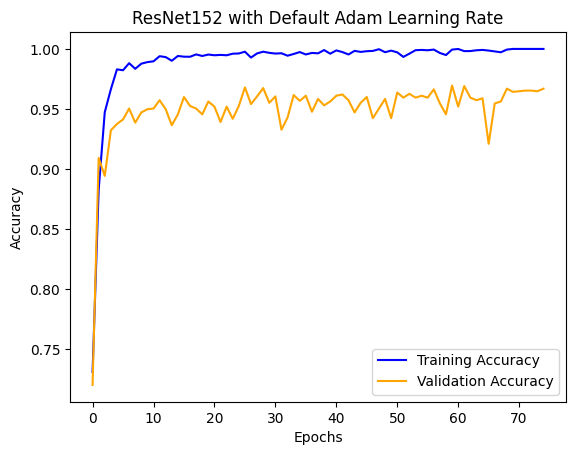

In [18]:
plt.plot(history.history['accuracy'],color='Blue',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],color='Orange',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("ResNet152 with Default Adam Learning Rate")
plt.legend()
plt.show()